In [1]:
import pandas as pd
import numpy as np
# from sklearn.ensemble import RandomForestRegressor, VotingRegressor
# from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from custom_model import RandomForestRegressor, XGBoostRegressor
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
def add_lag(dataframe, days):
    df_copy = dataframe.copy()
    
    for feature in ['Open', 'High', 'Low', 'Volume']:
        df_copy[f'{feature.lower()}_lag'] = dataframe[feature].shift(periods=days)
    
    return df_copy

In [3]:
def prepare_future_data(df, days_to_predict):
    date = df.index.max()
    last_date = pd.Timestamp(date)
    current_date = last_date + pd.Timedelta(days=1)       
    
    future_dates = []
    days_added = 0
    while days_added < days_to_predict:
        if current_date.weekday() < 5:
            future_dates.append(current_date)
            days_added += 1
        
        current_date += pd.Timedelta(days=1)
    
    # Create future dataframe with NaN values
    future_df = pd.DataFrame(index=future_dates,
                           columns=df.columns)
    
    # Combine historical and future data
    combined_df = pd.concat([df, future_df])
    
    # Add lag features
    combined_df = add_lag(combined_df, days=7)
    
    # For future dates, we only want to keep lag features
    future_feature_df = combined_df.loc[future_dates]
    
    # Keep only lag features for prediction
    features_for_prediction = ['open_lag', 'high_lag', 'low_lag', 'volume_lag']
    
    print(f'df: {df}')
    print(f'future: {future_df}')
    print(f'combined: {combined_df}')
    
    return future_feature_df[features_for_prediction], future_dates

In [4]:
ticker_market = yf.Ticker('BMRI.JK')
df = ticker_market.history(period='5y')
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [5]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2019-11-08 00:00:00+07:00,2773.549931,2843.137205,2723.844735,2823.255127,76355000
2019-11-11 00:00:00+07:00,2813.313596,2823.254633,2773.549446,2803.372559,45212000
2019-11-12 00:00:00+07:00,2783.491089,2823.255248,2753.667970,2793.432129,52900800
2019-11-13 00:00:00+07:00,2783.490838,2783.490838,2694.021490,2733.785645,75148400
2019-11-14 00:00:00+07:00,2733.785645,2743.726683,2664.198374,2733.785645,66698600
...,...,...,...,...,...
2024-11-04 00:00:00+07:00,6600.000000,6800.000000,6525.000000,6750.000000,80208800
2024-11-05 00:00:00+07:00,6725.000000,6950.000000,6675.000000,6925.000000,88661200
2024-11-06 00:00:00+07:00,6925.000000,6925.000000,6550.000000,6550.000000,147272800


In [6]:
df_with_lags = add_lag(df, days=30)
df_with_lags.dropna()

,Open,High,Low,Close,Volume,open_lag,high_lag,low_lag,volume_lag
Date,,,,,,,,,
2019-12-20 00:00:00+07:00,3002.193613,3061.839844,3002.193613,3061.839844,150472200,2773.549931,2843.137205,2723.844735,76355000.0
2019-12-23 00:00:00+07:00,3101.603629,3101.603629,3051.898443,3071.780518,131246800,2813.313596,2823.254633,2773.549446,45212000.0
2019-12-26 00:00:00+07:00,3091.662722,3111.544797,3081.721684,3101.603760,140936400,2783.491089,2823.255248,2753.667970,52900800.0
2019-12-27 00:00:00+07:00,3111.545039,3111.545039,3071.780885,3081.721924,58182800,2783.490838,2783.490838,2694.021490,75148400.0
2019-12-30 00:00:00+07:00,3071.781003,3101.604120,3041.957887,3051.898926,78005800,2733.785645,2743.726683,2664.198374,66698600.0
...,...,...,...,...,...,...,...,...,...
2024-11-04 00:00:00+07:00,6600.000000,6800.000000,6525.000000,6750.000000,80208800,7325.000000,7450.000000,7300.000000,79675600.0
2024-11-05 00:00:00+07:00,6725.000000,6950.000000,6675.000000,6925.000000,88661200,7400.000000,7475.000000,7375.000000,81817100.0
2024-11-06 00:00:00+07:00,6925.000000,6925.000000,6550.000000,6550.000000,147272800,7350.000000,7350.000000,7050.000000,192197100.0


In [7]:
features = ['open_lag','high_lag','low_lag','volume_lag']
target = ['Close']

X = df_with_lags[features].values
y = df_with_lags[target].values.ravel()

In [8]:
rf = RandomForestRegressor(n_estimators=250,
                                max_depth=20,
                                max_features=4,
                                min_samples_leaf=2,
                                min_samples_split=2)
xgb = XGBoostRegressor(n_estimators=250,
                eta=0.01,
                max_depth=12,
                subsample=0.3)
        
model = VotingRegressor(estimators=[
            ('rf', rf),
            ('xgb', xgb)
        ], weights=None)

In [9]:
model.fit(X, y)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=20, max_features=4,
                                                   min_samples_leaf=2,
                                                   n_estimators=250)),
                            ('xgb',
                             XGBoostRegressor(eta=0.01, max_depth=12,
                                              n_estimators=250,
                                              subsample=0.3))])

In [10]:
last_dates = df.index.max()

In [11]:
days_to_predict = 30
future_features, future_dates = prepare_future_data(df, days_to_predict)

TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union

In [ ]:
prediction_features = ['open_lag', 'high_lag', 'low_lag', 'volume_lag']
future_features[prediction_features] = future_features[prediction_features].astype('float64')
y_pred_future = model.predict(future_features[prediction_features])

c:\Users\ASUS\Documents\.mahasiswa\semester7\FileSkripsi\Skripsi\Code\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
y_pred_future

array([6570.17936376, 6859.09082403, 6709.08513472, 6354.92054548,
       6182.34585565, 6913.99711365, 6403.77571196, 2882.21275209,
       2882.21275209, 2882.21275209, 2882.21275209, 2882.21275209,
       2882.21275209, 2882.21275209, 2882.21275209, 2882.21275209,
       2882.21275209, 2882.21275209, 2882.21275209, 2882.21275209,
       2882.21275209, 2882.21275209, 2882.21275209, 2882.21275209,
       2882.21275209, 2882.21275209, 2882.21275209, 2882.21275209,
       2882.21275209, 2882.21275209])

In [ ]:
future_predictions = pd.DataFrame(
    y_pred_future,
    index=future_dates,
    columns=['Close']
)

historical_data = pd.DataFrame(df['Close'])
combined_df = pd.concat([historical_data, future_predictions])

combined_dates = combined_df.index
combined_close = combined_df['Close'].values

In [ ]:
# # rmse = root_mean_squared_error(y_test, y_pred)
# # r2 = r2_score(y_test, y_pred)
# rmse = root_mean_squared_error(y, y_pred)
# r2 = r2_score(y, y_pred)

# print(f'Nilai RMSE: {rmse}')
# print(f'Nilai R2: {r2}')

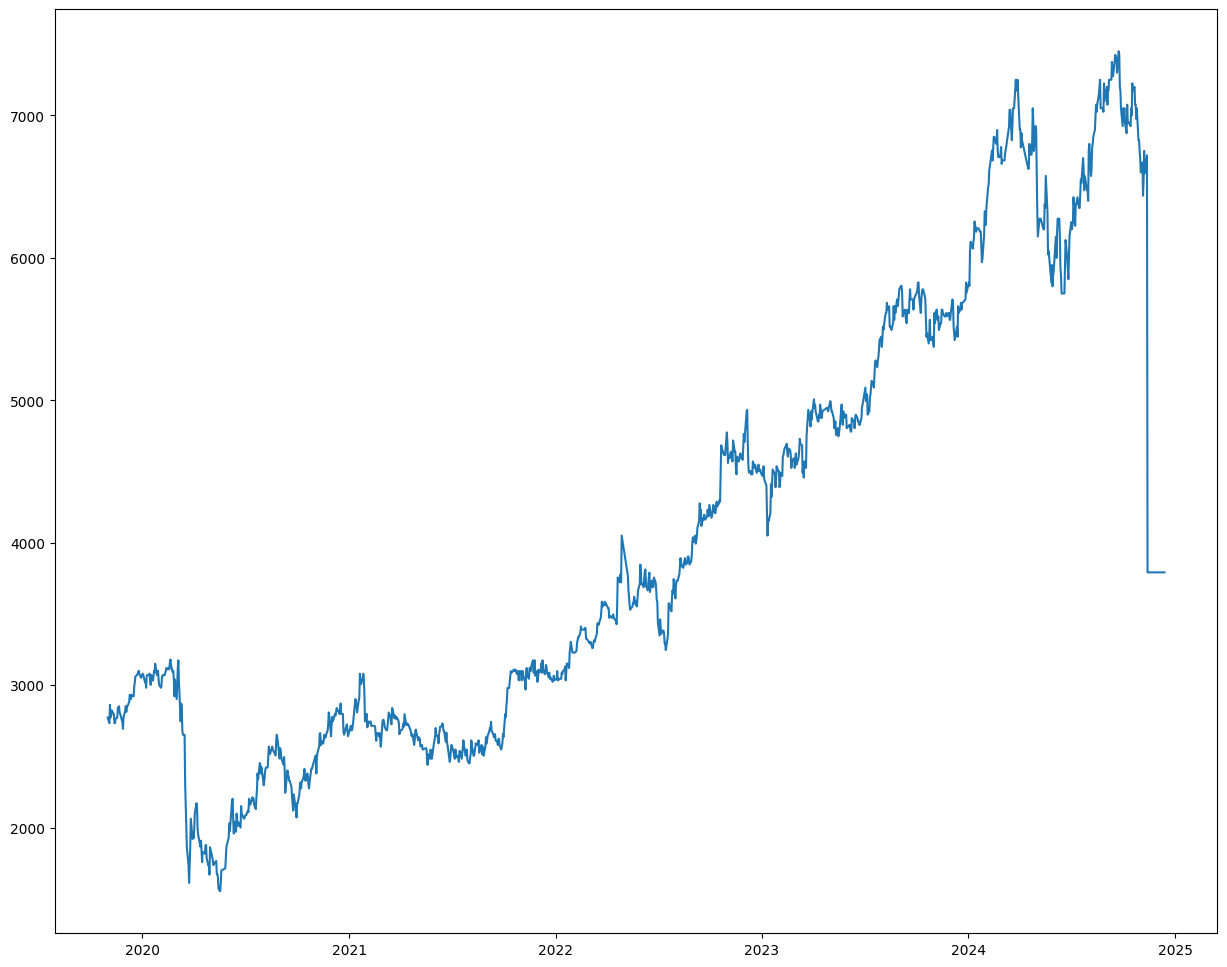

In [ ]:
plt.figure(figsize=(15,12))
plt.plot(combined_dates, combined_close)
plt.show()

In [ ]:
# ticker_market = yf.Ticker('BBCA.JK')

# df = ticker_market.history(period='5y')
# df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

# dates = df.index.strftime('%Y-%m-%d').tolist()

# close_actual = df['Close'].values.tolist()

In [ ]:
# df = df.drop(['Dividends','Stock Splits'], axis=1)
# df

In [ ]:
# def add_lag(dataframe, n_past):
#     # period = round((days * 5)/7)
#     # dataframe['lag'] = dataframe['Close'].shift(periods=period, freq='B')
#     # target_map = dataframe['Close'].to_dict()
#     # dataframe['lag'] = (dataframe.index - pd.Timedelta('364 days')).map(target_map)
    
#     df_copy = dataframe.copy()
#     # lag_offset = pd.offsets.BDay(days)
#     # lagged_index = df_copy.index - lag_offset

#     # for feature in ['Open', 'High', 'Low', 'Volume']:
#     #     target_map = dict(zip(df_copy.index, df_copy[feature]))
#     #     df_copy[f'{feature.lower()}_lag'] = lagged_index.map(target_map)
#     df_copy = df_copy.dropna()
    
#     price_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
#     for column in price_columns:
#         for lag in range(1, n_past + 1):
#             df_copy[f'{column}_lag{lag}'] = df_copy[column].shift(periods=lag, freq='B')
    
#     df_copy = df_copy.dropna()
    
#     return df_copy

In [ ]:
# df_featured = add_lag(df,7)
# df_featured
# features = df_featured.drop(columns=['Close'], axis=1)
# target = df_featured[['Close']]

# X = features
# y = target.values.ravel()

In [ ]:
# rf = RandomForestRegressor(n_estimators=100,
#                                 max_depth=20,
#                                 max_features=4,
#                                 min_samples_leaf=2,
#                                 min_samples_split=2)
# xgb = XGBRegressor(n_estimators=100,
#                 eta=0.2,
#                 max_depth=6,
#                 subsample=0.3)
        
# model = VotingRegressor(estimators=[
#             ('rf', rf),
#             ('xgb', xgb)
#         ], weights=None)

In [ ]:
model.fit(X,y)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=20, max_features=4,
                                                   min_samples_leaf=2,
                                                   n_estimators=250)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False, eta=0.01,
                                          eval_metric=None, feature...=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=12,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=250,
                                          n_jobs=None, num_parallel_tree=None, ...))])

In [ ]:
# n_past = 30
# days = 30

# last_data = df.tail(n_past + days).copy()
# predictions = []

# last_date = pd.to_datetime(df_featured.index[-1])
# dates_future = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days, freq='B')

# for _ in range(days):
#     features_df = add_lag(last_data, n_past)
#     last_features = features_df.iloc[[-1]]
    
    
#     # Make prediction
#     pred = model.predict(X)
#     predictions.append(pred)
    
#     # Update the data for the next prediction
#     new_row = last_data.iloc[-1].copy()
#     new_row['Close'] = pred
#     last_data = pd.concat([last_data, pd.DataFrame([new_row])])
    
# predictions = np.array(predictions)